# 1. Import and Install Dependencies

In [23]:
# !pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe sklearn matplotlib

In [25]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# 2. Keypoints using MP Holistic

In [26]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [27]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [28]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [29]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    # mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
    #                          mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
    #                          mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
    #                          ) 
    # # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [30]:
cap = cv2.VideoCapture(1)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [31]:
cap.release()
cv2.destroyAllWindows()

# 3. Extract Keypoint Values

In [109]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    # face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, lh, rh])

In [110]:
extract_keypoints(results).shape

(258,)

# 4. Setup Folders for Collection

In [111]:
# Actions that we try to detect
actions = np.array(['Terima Kasih'])

# Path for exported data, numpy arrays
DATA_PATH = os.path.join('./MP_Data') 

# Thirty videos worth of data
no_sequences = 80

# Videos are going to be 30 frames in length
sequence_length = 24

for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# 5. Collect Keypoint Values for Training and Testing

In [112]:
cap = cv2.VideoCapture(0)
stop = False
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)
#               print(results)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION {}'.format(action), (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {} Frame {}'.format(action, sequence, frame_num), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {} Frame {}'.format(action, sequence, frame_num), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    stop = True
                    break
            if stop:
                break
        if stop:
            break
                
    cap.release()
    cv2.destroyAllWindows()

In [113]:
import cv2
cap = cv2.VideoCapture(0)
cap.release()
cv2.destroyAllWindows()

# 6. Preprocess Data and Create Labels and Features

In [114]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [115]:
actions = os.listdir('./MP_Data')
actions = np.array(actions)

In [116]:
label_map = {label:num for num, label in enumerate(actions)}

In [117]:
label_map

{'Bapak': 0, 'Terima Kasih': 1}

In [118]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [119]:
X = np.array(sequences)

In [120]:
y = to_categorical(labels).astype(int)

In [121]:
y

array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1,

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

In [123]:
y_test.shape

(16, 2)

# 7. Build and Train LSTM Neural Network

In [124]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau
import tensorflow as tf

In [125]:
log_dir = os.path.join('Logs')
tb_callback = [
    TensorBoard(log_dir=log_dir),
    ReduceLROnPlateau(factor=0.1, patience=5)
]

In [126]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(24,258)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [127]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 24, 64)            82688     
                                                                 
 lstm_4 (LSTM)               (None, 24, 128)           98816     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 2)                

In [128]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [129]:
history = model.fit(X_train, y_train, 
                        epochs=40, 
                        callbacks=[tb_callback],
                        validation_data = (X_test, y_test))

Epoch 1/40
5/5 [==============================] - 7s 200ms/step - loss: 0.6794 - accuracy: 0.4931 - val_loss: 0.6521 - val_accuracy: 0.8125 - lr: 1.0000e-04
Epoch 2/40
5/5 [==============================] - 0s 41ms/step - loss: 0.6553 - accuracy: 0.7222 - val_loss: 0.6322 - val_accuracy: 0.8750 - lr: 1.0000e-04
Epoch 3/40
5/5 [==============================] - 0s 40ms/step - loss: 0.6318 - accuracy: 0.7153 - val_loss: 0.5986 - val_accuracy: 0.8750 - lr: 1.0000e-04
Epoch 4/40
5/5 [==============================] - 0s 38ms/step - loss: 0.5900 - accuracy: 0.8611 - val_loss: 0.5448 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 5/40
5/5 [==============================] - 0s 39ms/step - loss: 0.5405 - accuracy: 0.9444 - val_loss: 0.4361 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 6/40
5/5 [==============================] - 0s 39ms/step - loss: 0.4130 - accuracy: 0.9444 - val_loss: 0.2789 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 7/40
5/5 [==============================] - 0s 38ms/step 

Text(0.5, 1.0, 'Training and Validation Loss')

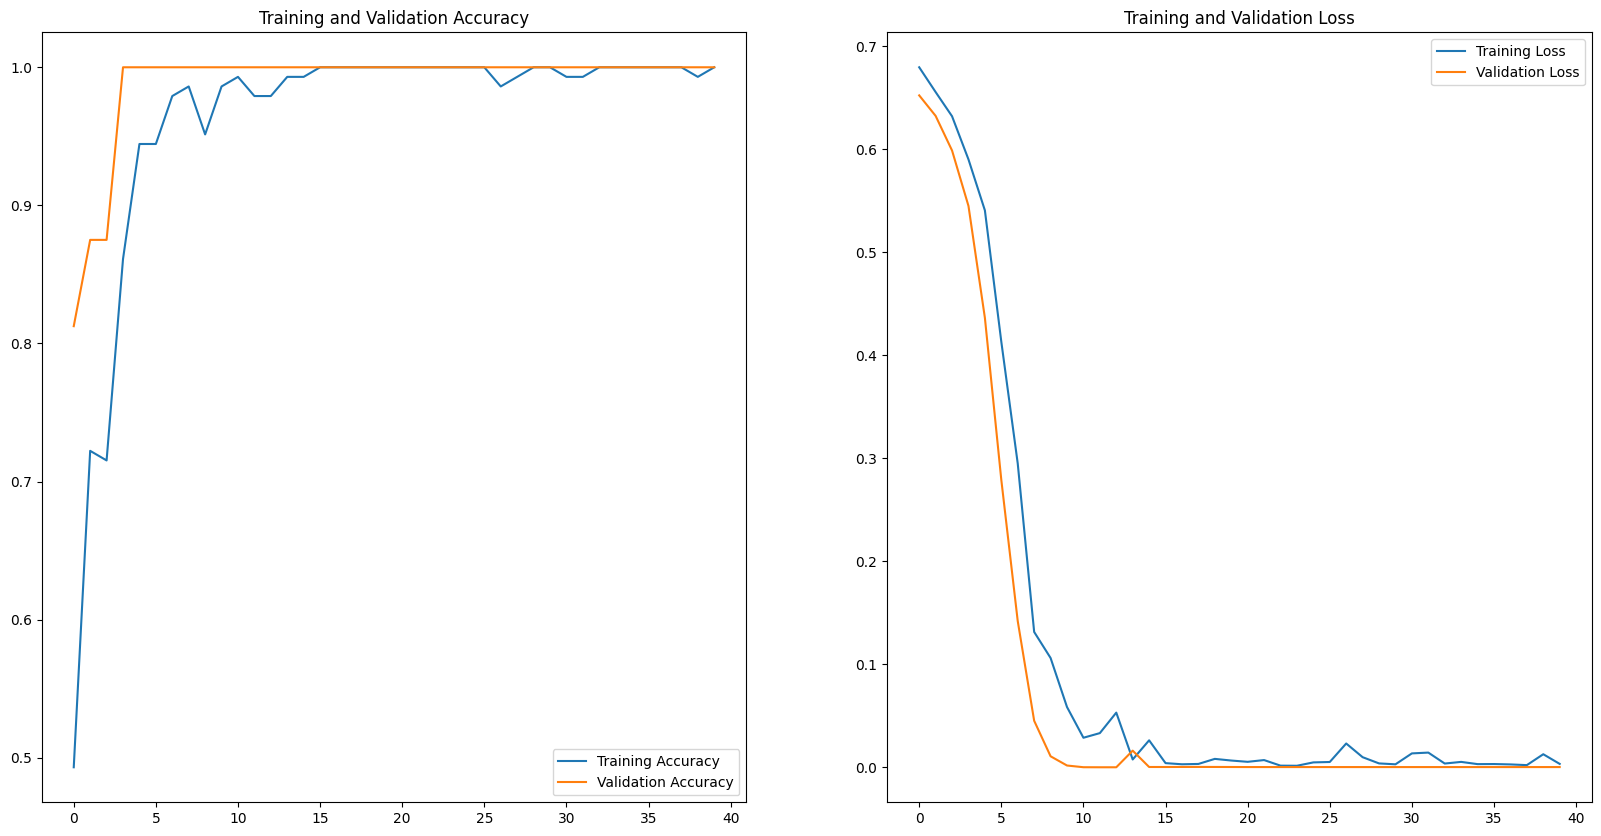

In [130]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = history.epoch

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# 8. Make Predictions

In [131]:
res = model.predict(X_test)

1/1 [==============================] - 1s 521ms/step


In [134]:
actions[np.argmax(res[11])]

'Bapak'

In [136]:
actions[np.argmax(y_test[11])]

'Bapak'

# 9. Save Weights

In [137]:
model.save('model_thirdrun.h5')

c:\Streamlit\dims\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [138]:
model.load_weights('model_thirdrun.h5')

# 10. Evaluation using Confusion Matrix and Accuracy

In [67]:
import tensorflow as tf

In [139]:
# Load model:
# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model('./model_thirdrun.h5')

# Show the model architecture
model.summary()

# We need to define its optimizer and loss function again since the h5 file
# does not contain those information :(
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 24, 64)            82688     
                                                                 
 lstm_4 (LSTM)               (None, 24, 128)           98816     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 2)                

In [69]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [140]:
yhat = model.predict(X_test)

1/1 [==============================] - 1s 877ms/step


In [141]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [142]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[8, 0],
        [0, 8]],

       [[8, 0],
        [0, 8]]], dtype=int64)

In [143]:
accuracy_score(ytrue, yhat)

1.0

# 11. Text to speak

In [63]:
!pip install pyttsx3

In [144]:
import pyttsx3

engine = pyttsx3.init()
voices = engine.getProperty('voices')
engine.say('see you later')
engine.runAndWait()

In [145]:
# Show all language
voice_lang = {idx: str(voice.languages[0]).split('5')[-1] for idx, voice in enumerate(voices)}
print(voice_lang)


IndexError: list index out of range

In [78]:
engine = pyttsx3.init()
voices = engine.getProperty('voices')
engine.setProperty('voice', voices[16].id)
engine.say('hello')
engine.runAndWait()

IndexError: list index out of range

# 12. Test in Real Time

In [79]:
res.sort()

In [148]:
pred_dict = dict(zip(actions, res))
prediction = sorted(pred_dict.items(), key=lambda x: x[1])[::-1]
prediction

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [146]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()

    pred_dict = dict(zip(actions, res))
    # sorting for prediction and get top 5
    prediction = sorted(pred_dict.items(), key=lambda x: x[1])[::-1][:5]

    for num, pred in enumerate(prediction):
        text = '{}: {}'.format(pred[0], pred[1])
        # cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, text, (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2, cv2.LINE_AA)
        
    return output_frame

In [147]:
# New detection variables
sequence = []
sentence = []
threshold = 0.9
tts = False

# Text to speak config:
engine = pyttsx3.init()
voices = engine.getProperty('voices')
engine.setProperty('voice', voices[16].id)

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.7, min_tracking_confidence=0.7) as holistic:
    while cap.isOpened():
        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)

        # sequence.insert(0,keypoints)
        # sequence = sequence[:24]
        sequence.append(keypoints)
        sequence = sequence[-24:]
        
        if len(sequence) == 24:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]

            #3. Viz logic
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                        tts = True
                else:
                    sentence.append(actions[np.argmax(res)])
                    tts = True

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)

            # Text to speak:
            if tts:
                engine.say(sentence[-1])
                tts = False
            engine.runAndWait()
            
            # 
            cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
            cv2.putText(image, ' '.join(sentence), (3,30), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
        
    cap.release()
    cv2.destroyAllWindows()

IndexError: list index out of range

## Check have 2 hands or not

In [94]:
# New detection variables
sequence = []
sentence = []
threshold = 0.87
tts = False

# Text to speak config:
engine = pyttsx3.init()
voices = engine.getProperty('voices')
engine.setProperty('voice', voices[16].id)

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.7, min_tracking_confidence=0.7) as holistic:
    while cap.isOpened():
        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # 2. Prediction logic
        # Check have 2 hands or not:
        # results.right_hand_landmarks.landmark
        keypoints = extract_keypoints(results)

        sequence.append(keypoints)
        sequence = sequence[-24:]

        if len(sequence) == 24:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]

            #3. Viz logic
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                        tts = True
                else:
                    sentence.append(actions[np.argmax(res)])
                    tts = True

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)

            # Text to speak:
            if tts:
                engine.say(sentence[-1])
                tts = False
            engine.runAndWait()

            cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
            cv2.putText(image, ' '.join(sentence), (3,30), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

        image = prob_viz(res, actions, image, colors)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
        
    cap.release()
    cv2.destroyAllWindows()

IndexError: list index out of range

In [97]:
cap.release()
cv2.destroyAllWindows()

In [98]:
res[np.argmax(res)] > threshold

array([False,  True])

In [99]:
(num_sequences,30,1662)

NameError: name 'num_sequences' is not defined

In [95]:
model.predict(np.expand_dims(X_test[0], axis=0))

1/1 [==============================] - 0s 38ms/step


array([[1.4926501e-18, 1.0000000e+00]], dtype=float32)